In [12]:
import pickle
import numpy as np
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import pearsonr
from sklearn.metrics import mutual_info_score


In [13]:
# links_coeffs = {
#     0: [((0, -1), 0.7, lin_f), ((1, -1), -0.8, lin_f)],
#     1: [((1, -1), 0.8, lin_f), ((3, -1), 0.8, lin_f)],
#     2: [((2, -1), 0.5, lin_f), ((1, -2), 0.5, lin_f), ((3, -3), 0.6, lin_f)],
#     3: [((3, -1), 0.4, lin_f)]
# }

# Loading data

In [14]:
df = pd.read_pickle('lin_df.pkl')

# Cross correlation method + Fourier

Variable 0 is influenced by:
  Variable 1 with lag -3 and coefficient -0.39
  Variable 2 with lag -3 and coefficient -0.62
Variable 1 is influenced by:
  Variable 0 with lag 3 and coefficient -0.39
  Variable 2 with lag -2 and coefficient 0.90
  Variable 3 with lag 2 and coefficient 0.48
Variable 2 is influenced by:
  Variable 0 with lag 3 and coefficient -0.62
  Variable 1 with lag 2 and coefficient 0.90
  Variable 3 with lag 3 and coefficient 0.48
Variable 3 is influenced by:
  Variable 1 with lag -2 and coefficient 0.48
  Variable 2 with lag -3 and coefficient 0.48


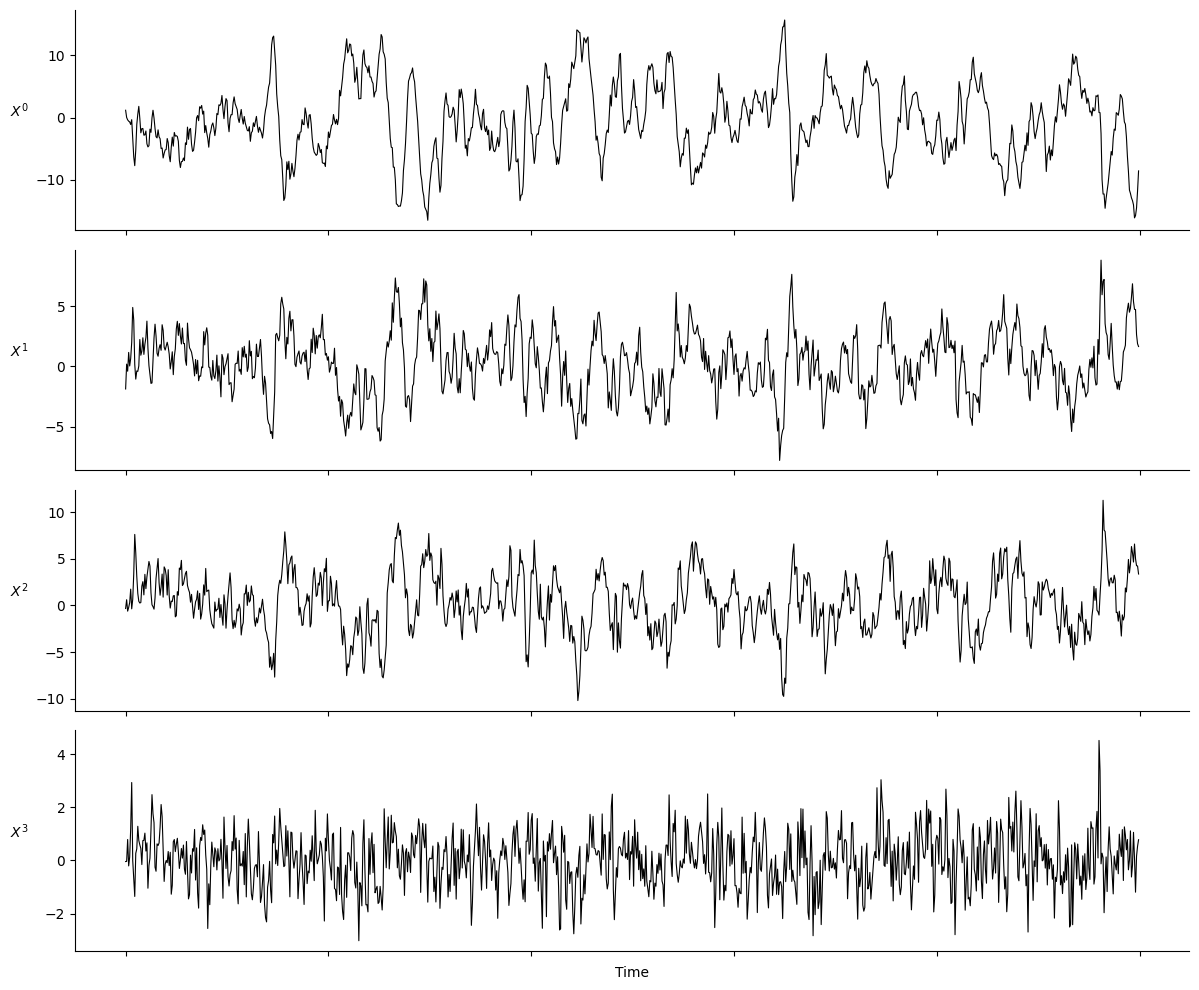

In [15]:


def fourier_analysis(data, sampling_rate=1.0):
    n = len(data)
    yf = fft(data)
    xf = fftfreq(n, 1 / sampling_rate)
    return xf[:n//2], np.abs(yf[:n//2])

def estimate_links_coeffs(df, threshold=0.5, max_lag=None):
    n_vars = len(df.columns)
    links_coeffs = {i: [] for i in range(n_vars)}
    
    if max_lag is None:
        max_lag = len(df) - 1
    
    for i in range(n_vars):
        x = df.iloc[:, i].values
        fx, fy = fourier_analysis(x)
        
        for j in range(n_vars):
            if i != j:
                y = df.iloc[:, j].values
                _, gy = fourier_analysis(y)
                
                # Compare frequency spectra
                corr, _ = pearsonr(fy, gy)
                if abs(corr) > threshold:
                    # Estimate lag by cross-correlation, limited by max_lag
                    cross_corr = np.correlate(x, y, mode='full')
                    mid_point = len(cross_corr) // 2
                    start = max(0, mid_point - max_lag)
                    end = min(len(cross_corr), mid_point + max_lag + 1)
                    lag = np.argmax(cross_corr[start:end]) + start - mid_point
                    
                    # Ensure both slices have the same length
                    if lag > 0:
                        x_slice = x[lag:]
                        y_slice = y[:-lag]
                    else:
                        x_slice = x[:lag]
                        y_slice = y[-lag:]
                    
                    # Make sure both slices have the same length
                    min_len = min(len(x_slice), len(y_slice))
                    x_slice = x_slice[:min_len]
                    y_slice = y_slice[:min_len]
                    
                    # Estimate coefficient
                    coeff = np.corrcoef(x_slice, y_slice)[0, 1]
                    
                    links_coeffs[i].append(((j, lag), coeff, 'fourier'))
    
    return links_coeffs


# Estimate links and coefficients with a maximum lag of 50
max_lag = 3
estimated_links_coeffs = estimate_links_coeffs(df, max_lag=max_lag)

# Print estimated links and coefficients
for i, links in estimated_links_coeffs.items():
    print(f"Variable {i} is influenced by:")
    for ((j, lag), coeff, _) in links:
        print(f"  Variable {j} with lag {lag} and coefficient {coeff:.2f}")

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
fig.subplots_adjust(hspace=0)

for i in range(4):
    axs[i].plot(df[f'x{i}'], color='black', linewidth=0.8)
    axs[i].set_ylabel(f'$X^{i}$', rotation=0, labelpad=10)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].yaxis.set_label_coords(-0.05, 0.5)

# Remove x-axis labels for all but the bottom subplot
for ax in axs[:-1]:
    ax.set_xticklabels([])

axs[-1].set_xlabel('Time')

plt.tight_layout()
plt.show()

# Mutual information + Fourier lag

/Users/vivekchaudhary/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/Users/vivekchaudhary/anaconda3/lib/python3.11/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/vivekchaudhary/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/vivekchaudhary/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/vivekchaudhary/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/vivekchaudhary/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
 

Variable 0 is influenced by:
  Variable 1 with lag 2 and coefficient -0.91
  Variable 2 with lag 0 and coefficient nan
Variable 1 is influenced by:
  Variable 0 with lag -2 and coefficient -0.91
  Variable 2 with lag -2 and coefficient 0.90
  Variable 3 with lag 2 and coefficient 0.48
Variable 2 is influenced by:
  Variable 0 with lag 0 and coefficient nan
  Variable 1 with lag 2 and coefficient 0.90
  Variable 3 with lag 4 and coefficient 0.52
Variable 3 is influenced by:
  Variable 1 with lag -2 and coefficient 0.48
  Variable 2 with lag -4 and coefficient 0.52


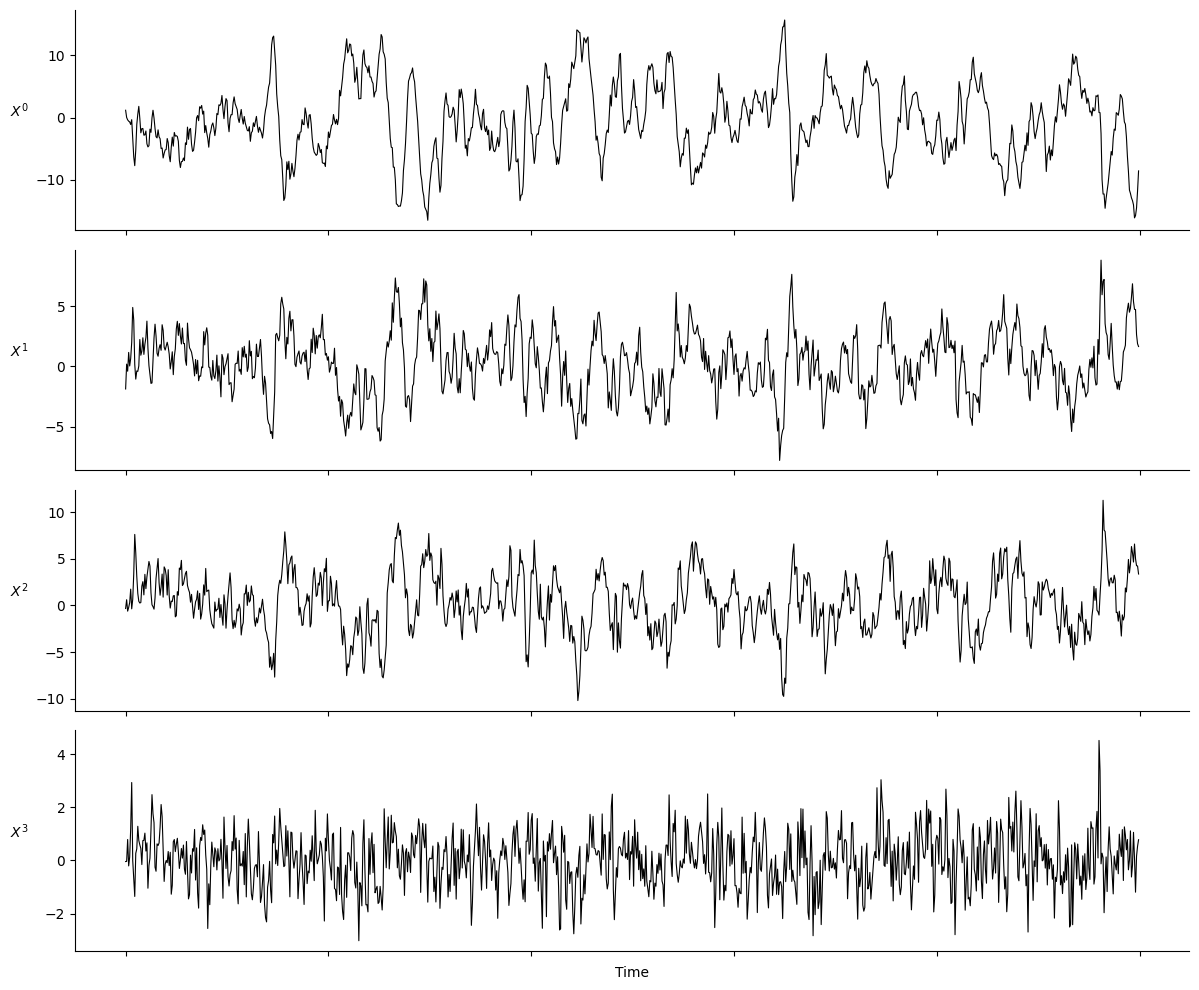

In [17]:

def fourier_analysis(data, sampling_rate=1.0):
    n = len(data)
    yf = fft(data)
    xf = fftfreq(n, 1 / sampling_rate)
    return xf[:n//2], np.abs(yf[:n//2])

def compute_mutual_info(x, y, bins=10):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

def estimate_lag_mi(x, y, max_lag=4):
    n = len(x)
    mi_scores = np.zeros(2 * max_lag + 1)
    
    for lag in range(-max_lag, max_lag + 1):
        if lag < 0:
            mi_scores[lag + max_lag] = compute_mutual_info(x[:lag], y[-lag:])
        elif lag > 0:
            mi_scores[lag + max_lag] = compute_mutual_info(x[lag:], y[:-lag])
        else:
            mi_scores[lag + max_lag] = compute_mutual_info(x, y)
    
    return np.argmax(mi_scores) - max_lag

def estimate_links_coeffs(df, threshold=0.5, max_lag=100):
    n_vars = len(df.columns)
    links_coeffs = {i: [] for i in range(n_vars)}
    
    for i in range(n_vars):
        x = df.iloc[:, i].values
        fx, fy = fourier_analysis(x)
        
        for j in range(n_vars):
            if i != j:
                y = df.iloc[:, j].values
                _, gy = fourier_analysis(y)
                
                # Compare frequency spectra
                corr, _ = pearsonr(fy, gy)
                if abs(corr) > threshold:
                    # Estimate lag using mutual information
                    lag = estimate_lag_mi(x, y, max_lag)
                    
                    # Ensure both slices have the same length
                    if lag > 0:
                        x_slice = x[lag:]
                        y_slice = y[:-lag]
                    else:
                        x_slice = x[:lag]
                        y_slice = y[-lag:]
                    
                    # Make sure both slices have the same length
                    min_len = min(len(x_slice), len(y_slice))
                    x_slice = x_slice[:min_len]
                    y_slice = y_slice[:min_len]
                    
                    # Estimate coefficient
                    coeff = np.corrcoef(x_slice, y_slice)[0, 1]
                    
                    links_coeffs[i].append(((j, lag), coeff, 'fourier_mi'))
    
    return links_coeffs


# Estimate links and coefficients
estimated_links_coeffs = estimate_links_coeffs(df)

# Print estimated links and coefficients
for i, links in estimated_links_coeffs.items():
    print(f"Variable {i} is influenced by:")
    for ((j, lag), coeff, _) in links:
        print(f"  Variable {j} with lag {lag} and coefficient {coeff:.2f}")

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
fig.subplots_adjust(hspace=0)

for i in range(4):
    axs[i].plot(df[f'x{i}'], color='black', linewidth=0.8)
    axs[i].set_ylabel(f'$X^{i}$', rotation=0, labelpad=10)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].yaxis.set_label_coords(-0.05, 0.5)

# Remove x-axis labels for all but the bottom subplot
for ax in axs[:-1]:
    ax.set_xticklabels([])

axs[-1].set_xlabel('Time')

plt.tight_layout()
plt.show()

# Simplified approach

In [18]:
df['x3_1'] = df['x3'].shift(1)

df.head(3)

,x0,x1,x2,x3,x3_1
0,1.174814,-1.878981,-0.327795,-0.041660,NaN
1,0.015909,0.180496,0.610440,-0.035407,-0.041660
2,-0.368058,-0.407589,-0.611516,0.787543,-0.035407
